In [1]:
import xml.etree.ElementTree as ET
import SimpleITK as sitk
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.ndimage
from tqdm import tqdm
from glob import glob
from random import shuffle

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras as k
from keras.models import Sequential ,Model
from keras.layers import Conv2D, MaxPooling2D,AveragePooling3D,AveragePooling2D,MaxPooling3D,Conv3D
from keras.layers import Activation, Dropout, Flatten, Dense ,Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing import image
from keras import applications

from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

Using TensorFlow backend.


In [3]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def readCSV(filename):
    lines = []
    with open(filename, "rb") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray


In [3]:
outdir = "cropsout/"

In [9]:
count=0
for xmln in tqdm(glob("tcia-lidc-xml/*/*.xml")):
    tree = ET.parse(xmln)
    root = tree.getroot()
    
    try:
        seriesID = (root.find("{http://www.nih.gov}ResponseHeader")).find("{http://www.nih.gov}SeriesInstanceUid")
        path = glob("../subset*/"+seriesID.text+".mhd")
        if len(path)>0:
            for reading in root.findall("{http://www.nih.gov}readingSession"):
                for unblindedread in reading.findall("{http://www.nih.gov}unblindedReadNodule"):
                    if unblindedread.find("{http://www.nih.gov}characteristics") !=None:
                        sumx=0
                        sumy=0
                        sumz=0
                        malignancy =int(unblindedread.find("{http://www.nih.gov}characteristics").find("{http://www.nih.gov}malignancy").text)
                        countz=0
                        countxy=0
                        for roi in unblindedread.findall("{http://www.nih.gov}roi"):
                            sumz= sumz+float(roi.find("{http://www.nih.gov}imageZposition").text)
                            countz = countz+1
                            for edge in roi.findall("{http://www.nih.gov}edgeMap"):
                                sumx=sumx + float(edge.find(("{http://www.nih.gov}xCoord")).text)
                                sumy=sumy+float(edge.find(("{http://www.nih.gov}yCoord")).text)
                                countxy = countxy+1
                        sumx=sumx/countxy
                        sumy=sumy/countxy
                        sumz=sumz/countz

                        numpyImage, numpyOrigin, numpySpacing = load_itk_image(path[0])
                        worldCoord = np.asarray([sumz,sumy,sumx])
                        voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
                        voxelCoord = np.asarray([voxelCoord[0],sumy,sumx])
                        voxelWidth = 64
                        patch = numpyImage[int(voxelCoord[0]-voxelWidth/2):int(voxelCoord[0]+voxelWidth/2),int(voxelCoord[1]-voxelWidth/2):int(voxelCoord[1]+voxelWidth/2),int(voxelCoord[2]-voxelWidth/2):int(voxelCoord[2]+voxelWidth/2)]
                        patch = normalizePlanes(patch)

                        desired= malignancy

                        if(desired==0):
                            yy = [0,0,0,0,0,1]
                        if(desired==1):
                            yy = [0,0,0,0,1,0]
                        if(desired==2):
                            yy = [0,0,0,1,0,0]
                        if(desired==3):
                            yy = [0,0,1,0,0,0]
                        if(desired==4):
                            yy = [0,1,0,0,0,0]
                        if(desired==5):
                            yy = [1,0,0,0,0,0]

                        np.save(outdir+str(count)+"X.npy",patch)
                        np.save(outdir+str(count)+"Y.npy",yy)

                        count= count+1

                        #print(sumz,sumx,sumy,malignancy)
    except:
        print("NOT IN DATASET")
                    


  0%|          | 0/1318 [00:00<?, ?it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  1%|          | 15/1318 [00:00<00:38, 33.82it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  3%|▎         | 37/1318 [00:01<00:46, 27.83it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  4%|▍         | 53/1318 [00:01<00:41, 30.81it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  6%|▌         | 75/1318 [00:02<00:48, 25.83it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  7%|▋         | 92/1318 [00:03<00:41, 29.70it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  8%|▊         | 102/1318 [00:03<00:46, 25.95it/s]

NOT IN DATASET


  8%|▊         | 106/1318 [00:05<01:02, 19.32it/s]

NOT IN DATASET


  8%|▊         | 109/1318 [00:06<01:07, 17.83it/s]

NOT IN DATASET


  8%|▊         | 111/1318 [00:06<01:08, 17.50it/s]

NOT IN DATASET
NOT IN DATASET


  9%|▉         | 118/1318 [00:07<01:18, 15.35it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


  9%|▉         | 125/1318 [00:07<01:15, 15.78it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 10%|█         | 135/1318 [00:08<01:11, 16.54it/s]

NOT IN DATASET


 11%|█         | 143/1318 [00:09<01:17, 15.19it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 11%|█▏        | 149/1318 [00:09<01:16, 15.24it/s]

NOT IN DATASET


 12%|█▏        | 153/1318 [00:10<01:17, 15.05it/s]

NOT IN DATASET


 12%|█▏        | 156/1318 [00:10<01:19, 14.61it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 12%|█▏        | 163/1318 [00:11<01:23, 13.89it/s]

NOT IN DATASET
NOT IN DATASET


 13%|█▎        | 168/1318 [00:12<01:28, 13.02it/s]

NOT IN DATASET
NOT IN DATASET


 13%|█▎        | 175/1318 [00:13<01:31, 12.54it/s]

NOT IN DATASET


 14%|█▎        | 180/1318 [00:14<01:33, 12.22it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 14%|█▍        | 188/1318 [00:15<01:31, 12.39it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 15%|█▍        | 194/1318 [00:15<01:31, 12.24it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 15%|█▌        | 202/1318 [00:16<01:31, 12.20it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 16%|█▌        | 211/1318 [00:17<01:32, 11.91it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 17%|█▋        | 224/1318 [00:18<01:30, 12.07it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 17%|█▋        | 229/1318 [00:18<01:29, 12.18it/s]

NOT IN DATASET


 18%|█▊        | 232/1318 [00:19<01:31, 11.88it/s]

NOT IN DATASET


 18%|█▊        | 235/1318 [00:20<01:33, 11.61it/s]

NOT IN DATASET
NOT IN DATASET


 18%|█▊        | 239/1318 [00:22<01:40, 10.77it/s]

NOT IN DATASET


 19%|█▉        | 248/1318 [00:22<01:38, 10.84it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 19%|█▉        | 253/1318 [00:24<01:41, 10.50it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 20%|█▉        | 261/1318 [00:27<01:49,  9.64it/s]

NOT IN DATASET


 21%|██        | 276/1318 [00:28<01:46,  9.78it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 21%|██▏       | 281/1318 [00:29<01:48,  9.54it/s]

NOT IN DATASET


 22%|██▏       | 284/1318 [00:31<01:53,  9.14it/s]

NOT IN DATASET


 22%|██▏       | 291/1318 [00:34<02:00,  8.49it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 23%|██▎       | 306/1318 [00:34<01:54,  8.84it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 24%|██▍       | 322/1318 [00:35<01:49,  9.11it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 27%|██▋       | 353/1318 [00:36<01:39,  9.68it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 27%|██▋       | 359/1318 [00:37<01:41,  9.45it/s]

NOT IN DATASET


 28%|██▊       | 363/1318 [00:38<01:41,  9.43it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 29%|██▉       | 384/1318 [00:38<01:34,  9.85it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 30%|██▉       | 392/1318 [00:40<01:34,  9.79it/s]

NOT IN DATASET
NOT IN DATASET


 30%|███       | 399/1318 [00:43<01:40,  9.10it/s]

NOT IN DATASET


 30%|███       | 401/1318 [00:44<01:41,  9.04it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 31%|███       | 409/1318 [00:46<01:44,  8.73it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 31%|███▏      | 414/1318 [00:47<01:42,  8.79it/s]

NOT IN DATASET


 32%|███▏      | 418/1318 [00:47<01:42,  8.78it/s]

NOT IN DATASET


 32%|███▏      | 427/1318 [00:49<01:42,  8.67it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 33%|███▎      | 433/1318 [00:50<01:43,  8.56it/s]

NOT IN DATASET
NOT IN DATASET


 33%|███▎      | 438/1318 [00:51<01:43,  8.48it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 34%|███▍      | 453/1318 [00:52<01:40,  8.64it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 36%|███▌      | 475/1318 [00:53<01:34,  8.90it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 37%|███▋      | 483/1318 [00:53<01:33,  8.96it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 37%|███▋      | 490/1318 [00:54<01:31,  9.01it/s]

NOT IN DATASET


 38%|███▊      | 495/1318 [00:54<01:31,  9.00it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 38%|███▊      | 502/1318 [00:56<01:31,  8.94it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 39%|███▊      | 509/1318 [00:57<01:30,  8.93it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 39%|███▉      | 519/1318 [00:57<01:28,  9.03it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 63%|██████▎   | 825/1318 [02:54<01:44,  4.74it/s]

NOT IN DATASET


 67%|██████▋   | 878/1318 [03:08<01:34,  4.65it/s]

NOT IN DATASET


 78%|███████▊  | 1028/1318 [03:33<01:00,  4.81it/s]

NOT IN DATASET


 81%|████████  | 1068/1318 [03:40<00:51,  4.84it/s]

NOT IN DATASET


 81%|████████▏ | 1071/1318 [03:41<00:51,  4.84it/s]

NOT IN DATASET
NOT IN DATASET


 83%|████████▎ | 1092/1318 [03:43<00:46,  4.88it/s]

NOT IN DATASET


 83%|████████▎ | 1094/1318 [03:44<00:45,  4.88it/s]

NOT IN DATASET
NOT IN DATASET


 87%|████████▋ | 1153/1318 [03:56<00:33,  4.88it/s]

NOT IN DATASET
NOT IN DATASET
NOT IN DATASET
NOT IN DATASET


 93%|█████████▎| 1232/1318 [04:19<00:18,  4.76it/s]

NOT IN DATASET


 94%|█████████▍| 1238/1318 [04:19<00:16,  4.78it/s]

NOT IN DATASET


 97%|█████████▋| 1278/1318 [04:40<00:08,  4.56it/s]

NOT IN DATASET


 98%|█████████▊| 1298/1318 [04:46<00:04,  4.53it/s]

NOT IN DATASET


100%|██████████| 1318/1318 [04:48<00:00,  4.58it/s]


In [38]:
xtrain , ytrain= [] ,[]
l1 = glob(outdir+"*X.npy")
ll = l1[:]
shuffle(ll)
for x in ll:
    y = x[:-5] +"Y" + x[-4:]
    xx= np.load(x)
    yy = np.load(y)
    if xx.shape == (64,64,64):
        xx = np.expand_dims(xx,axis=3)
        xtrain.append(xx)
        ytrain.append(yy)

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

xtrain.shape , ytrain.shape

((2264, 64, 64, 64, 1), (2264, 6))

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=[64,64,64]))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

In [20]:
model.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('malignancy_crop.hdf5', monitor='loss', save_best_only=True)

In [ ]:
model.load_weights("malignancy_crop.hdf5")

In [22]:

model.fit(xtrain, ytrain,
          batch_size=1000,
          epochs=100,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

Train on 2037 samples, validate on 227 samples
Epoch 1/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9960 - acc: 0.5974 - val_loss: 1.3103 - val_acc: 0.4537
Epoch 2/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9727 - acc: 0.6038 - val_loss: 1.2799 - val_acc: 0.4405
Epoch 3/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9748 - acc: 0.6136 - val_loss: 1.2739 - val_acc: 0.4449
Epoch 4/100
2037/2037 [==============================] - 4s 2ms/step - loss: 1.0253 - acc: 0.5866 - val_loss: 1.2993 - val_acc: 0.4273
Epoch 5/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9991 - acc: 0.5920 - val_loss: 1.2890 - val_acc: 0.4449
Epoch 6/100
2037/2037 [==============================] - 4s 2ms/step - loss: 1.0100 - acc: 0.5857 - val_loss: 1.2912 - val_acc: 0.4229
Epoch 7/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9890 - acc: 0.5965 - val_loss: 1.3649 - val_acc: 0.4097
Epoch 8/

Epoch 61/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9252 - acc: 0.6264 - val_loss: 1.3035 - val_acc: 0.4537
Epoch 62/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9244 - acc: 0.6210 - val_loss: 1.2737 - val_acc: 0.4537
Epoch 63/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.8990 - acc: 0.6215 - val_loss: 1.2768 - val_acc: 0.4581
Epoch 64/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9340 - acc: 0.6082 - val_loss: 1.3184 - val_acc: 0.4185
Epoch 65/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9260 - acc: 0.6259 - val_loss: 1.2997 - val_acc: 0.4361
Epoch 66/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9445 - acc: 0.6053 - val_loss: 1.2904 - val_acc: 0.4626
Epoch 67/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.9195 - acc: 0.6240 - val_loss: 1.3076 - val_acc: 0.4449
Epoch 68/100
2037/2037 [========================

In [33]:
count0=0
count1=0
count2=0
count3=0
count4=0
count5=0


for y in ytrain:
    if np.argmax(y)==0:
        count0=count0+1
        
    if np.argmax(y)==1:
        count1=count1+1
        
    if np.argmax(y)==2:
        count2=count2+1
        
    if np.argmax(y)==3:
        count3=count3+1
        
    if np.argmax(y)==4:
        count4=count4+1
        
    if np.argmax(y)==5:
        count5=count5+1
    
print(count0,count1,count2,count3,count4,count5)

221 322 843 532 345 1


In [6]:
img_rows = 64
img_cols=64
channels=64
num_classes = 6

In [7]:
INIT_LR = 1e-3
middle_layers_activation = "relu"

last_layer_activation = "softmax"

batch_size = 500
epochs = 30

In [35]:
input_shape = (img_rows, img_cols, channels)

model1 = Sequential()

model1.add(Conv2D(20, (5, 5), padding="same",

        input_shape=input_shape))

model1.add(Activation(middle_layers_activation))
model1.add(Dropout(0.2))

model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model1.add(Conv2D(50, (5, 5), padding="same"))

model1.add(Activation(middle_layers_activation))

model1.add(Dropout(0.2))

model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))   

model1.add(Flatten())

model1.add(Dense(500))

model1.add(Activation(middle_layers_activation)) 

model1.add(Dropout(0.3))
model1.add(Dense(num_classes))

model1.add(Activation(last_layer_activation))

opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)

model1.compile(loss="binary_crossentropy",

              optimizer=opt,

              metrics=['accuracy'])




In [36]:
model_checkpoint = ModelCheckpoint('lenetdel.hdf5', monitor='loss', save_best_only=True)

In [31]:
model1.load_weights('lenet.hdf5')

In [37]:
history = model1.fit(xtrain, ytrain,
                   batch_size = 60, epochs=100, shuffle=True,  validation_split=0.1 , callbacks = [model_checkpoint])


Train on 2037 samples, validate on 227 samples
Epoch 1/100
2037/2037 [==============================] - 5s 2ms/step - loss: 0.4871 - acc: 0.8250 - val_loss: 0.4037 - val_acc: 0.8333
Epoch 2/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3909 - acc: 0.8309 - val_loss: 0.3943 - val_acc: 0.8333
Epoch 3/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3778 - acc: 0.8315 - val_loss: 0.3818 - val_acc: 0.8333
Epoch 4/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3700 - acc: 0.8333 - val_loss: 0.3765 - val_acc: 0.8326
Epoch 5/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3543 - acc: 0.8370 - val_loss: 0.3745 - val_acc: 0.8341
Epoch 6/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3412 - acc: 0.8438 - val_loss: 0.3727 - val_acc: 0.8282
Epoch 7/100
2037/2037 [==============================] - 4s 2ms/step - loss: 0.3275 - acc: 0.8477 - val_loss: 0.3655 - val_acc: 0.8414
Epoch 8/

KeyboardInterrupt: 

In [18]:
from sklearn.metrics import confusion_matrix

In [27]:
predicted = model1.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

array([[179,  11,  26,   3,   2,   0],
       [ 21, 218,  63,  18,   2,   0],
       [ 16,  37, 729,  48,  13,   0],
       [ 10,  25, 110, 378,   9,   0],
       [  2,   8,  26,  15, 294,   0],
       [  0,   0,   0,   0,   0,   1]])

In [ ]:
#SEA born

In [33]:
def plotmymodel(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


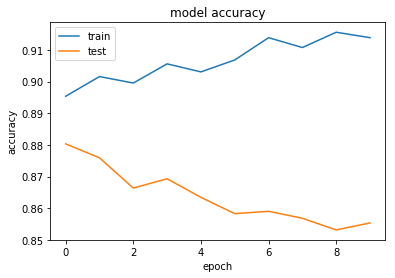

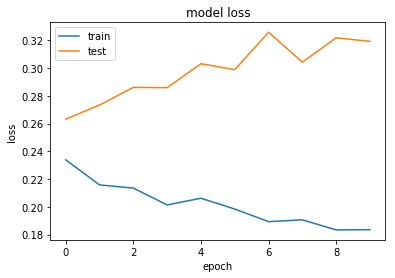

In [34]:
plotmymodel(history)

In [39]:
def inceptionlayer(prev):
    tower_1 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_1 = Conv3D(64, (3,3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv3D(64, (1,1,1), padding='same', activation='relu')(prev)
    tower_2 = Conv3D(64, (5,5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling3D((3,3,3), strides=(1,1,1), padding='same')(prev)
    tower_3 = Conv3D(64, (1,1,1), padding='same', activation='relu')(tower_3)
    output = k.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    
    return output

In [50]:
#GOOGLENET
def makegooglenet():
    x    = Input(shape=(64,64,64,1))
    conv1= Conv3D(32,kernel_size=(7,7,7),activation='relu')(x)
    conv1= Dropout(0.3)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(32,kernel_size=(3,3,3),activation='relu')(max1)
    conv2= Dropout(0.3)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    incp1= inceptionlayer(max2)
    incp1= Dropout(0.3)(incp1)
    incp2= inceptionlayer(incp1)
    incp2= Dropout(0.3)(incp2)
    max3 = MaxPooling3D(pool_size=(2,2,2))(incp2)
    incp3= inceptionlayer(max3)
    incp3= Dropout(0.3)(incp3)
    incp4= inceptionlayer(incp3)
    incp4= Dropout(0.3)(incp4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(incp4)
    incp5= inceptionlayer(max4)
    incp5= Dropout(0.3)(incp5)
    incp6= inceptionlayer(incp5)
    incp6= Dropout(0.3)(incp6)
    avg1= AveragePooling3D(pool_size=(2,2,2))(incp4)

    flat = Flatten()(avg1)
    flat= Dropout(0.3)(flat)
    dense= Dense(num_classes,activation="softmax")(flat)

    googlenet = Model(inputs=x, outputs=dense)
    
    googlenet.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
    
    return googlenet
    
   
   

In [51]:
googlenet = makegooglenet()
googlenet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 64, 1 0                                            
__________________________________________________________________________________________________
conv3d_68 (Conv3D)              (None, 58, 58, 58, 3 11008       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 58, 58, 58, 3 0           conv3d_68[0][0]                  
__________________________________________________________________________________________________
max_pooling3d_24 (MaxPooling3D) (None, 29, 29, 29, 3 0           dropout_35[0][0]                 
__________________________________________________________________________________________________
conv3d_69 

In [52]:
model_checkpoint = ModelCheckpoint('weights3d_malignancy_googlenet.hdf5', monitor='loss', save_best_only=True)


In [53]:
googlenet.load_weights('weights3d_malignancy_googlenet.hdf5')

In [ ]:
history= googlenet.fit(xtrain, ytrain,
          batch_size=20,
          epochs=5,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

Train on 2037 samples, validate on 227 samples
Epoch 1/5
2037/2037 [==============================] - 107s 53ms/step - loss: 0.9185 - acc: 0.6038 - val_loss: 1.4183 - val_acc: 0.2907
Epoch 2/5
 940/2037 [============>.................] - ETA: 55s - loss: 0.8594 - acc: 0.6298

In [27]:
from sklearn.metrics import confusion_matrix
predicted = googlenet.predict(xtrain[:])
pre = np.argmax(predicted,axis=1)
tru = np.argmax(ytrain[:],axis=1)
confusion_matrix(tru, pre)

array([[  0,   0, 221,   0,   0,   0],
       [  0,   0, 322,   0,   0,   0],
       [  0,   0, 843,   0,   0,   0],
       [  0,   0, 532,   0,   0,   0],
       [  0,   0, 345,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0]])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


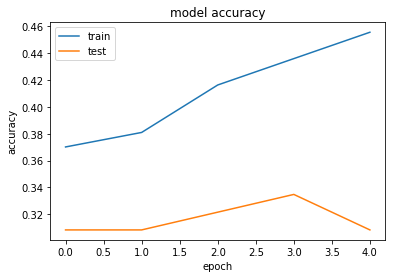

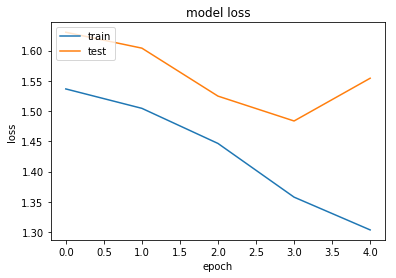

In [17]:
plotmymodel(history)

In [22]:
#Vanilla3d
def makevanilla():
    x    = Input(shape=(64,64,64,1))
    conv0= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(x)
    conv0= Dropout(0.2)(conv0)
    avg1 = AveragePooling3D(pool_size=(2,1,1))(conv0)
    conv1= Conv3D(32,kernel_size=(3,3,3),padding="same",activation='relu')(avg1)
    conv1= Dropout(0.2)(conv1)
    max1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2= Conv3D(64,kernel_size=(3,3,3),padding="same",activation='relu')(max1)
    conv2= Dropout(0.2)(conv2)
    max2 = MaxPooling3D(pool_size=(2,2,2))(conv2)
    conv3= Conv3D(128,kernel_size=(3,3,3),padding="same",activation='relu')(max2)
    conv3= Dropout(0.2)(conv3)
    max3 = MaxPooling3D(pool_size=(2,2,2))(conv3)
    conv4= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max3)
    conv4= Dropout(0.2)(conv4)
    max4 = MaxPooling3D(pool_size=(2,2,2))(conv4)
    conv5= Conv3D(256,kernel_size=(3,3,3),padding="same",activation='relu')(max4)
    conv5= Dropout(0.2)(conv5)
    max5 = MaxPooling3D(pool_size=(2,2,2))(conv5)
    conv6= Conv3D(512,kernel_size=(3,3,3),padding="same",activation='relu')(max5)

    flat = Flatten()(conv6)
    flat= Dropout(0.2)(flat)
    dense= Dense(num_classes,activation="softmax")(flat)

    vanillamodel = Model(inputs=x, outputs=dense)
    
    vanillamodel.compile(loss=k.losses.categorical_crossentropy,
              optimizer=k.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

    return vanillamodel

In [23]:
vanilla3d = makevanilla()
vanilla3d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 64, 64, 64, 32)    896       
_________________________________________________________________
dropout_19 (Dropout)         (None, 64, 64, 64, 32)    0         
_________________________________________________________________
average_pooling3d_3 (Average (None, 32, 64, 64, 32)    0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 32, 64, 64, 32)    27680     
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 64, 64, 32)    0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 16, 32, 32, 32)    0         
__________

In [24]:
model_checkpoint = ModelCheckpoint('weights3d_maliganancy_vanila.hdf5', monitor='loss', save_best_only=True)

In [25]:
vanilla3d.fit(xtrain, ytrain,
          batch_size=20,
          epochs=10,
          verbose=1,
          validation_split=0.1,
          callbacks=[model_checkpoint])

Train on 2037 samples, validate on 227 samples
Epoch 1/10
2037/2037 [==============================] - 96s 47ms/step - loss: 1.5835 - acc: 0.3201 - val_loss: 1.5631 - val_acc: 0.3128
Epoch 2/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.5152 - acc: 0.3780 - val_loss: 1.5208 - val_acc: 0.3128
Epoch 3/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.5063 - acc: 0.3790 - val_loss: 1.5200 - val_acc: 0.3128
Epoch 4/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.4921 - acc: 0.3760 - val_loss: 1.4512 - val_acc: 0.3128
Epoch 5/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.4465 - acc: 0.3913 - val_loss: 1.4795 - val_acc: 0.3128
Epoch 6/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.4054 - acc: 0.4011 - val_loss: 1.4101 - val_acc: 0.3216
Epoch 7/10
2037/2037 [==============================] - 92s 45ms/step - loss: 1.3521 - acc: 0.4119 - val_loss: 1.4093 - val_acc: 0.3172
E

KeyboardInterrupt: 